# BPZ mocks
This is a notebook to generate a realistic photometric survey catalog.
It uses a system of galaxy SED templates, here based on the CWW library as packed in the BPZ code. For convenience the SEDs and SDSS filters are also packaged in the repository. However, this code requires BPZ 1.99. Various BPZ routines are used, including the type-magnitude-redshift priors. The depth/selection function mimick that of a real survey thanks to realistic noise and selection models. The likelihood function is also taken from BPZ. However, unlike in BPZ  it is properly binned into a coarce resolution. The final product of this notebook is a set of noisy fluxes, redshifts, and galaxy types based on the CWW SEDs.

In [ ]:
%matplotlib inline
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline, interp1d

import seaborn as sns 
import itertools
sns.set_style("whitegrid")
sns.set_style("white")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
flatui = ["#9b59b6", "#95a5a6", "#e74c3c", "#3498db", "#34495e", "#2ecc71"]
sns.set_palette(sns.color_palette(flatui))

# Set to where BPZ is.
bpzdir = '/Users/bl/Dropbox/software/bpz-1.99.3/'
sys.path.append(bpzdir)
from prior_hdfn_gen import function as bpz_prior
from bpz_tools import *
# This loaded a bunch of functions from BPZ. Some of them are weirdly named.
# If you don't like that dangerous import, import them one by one.

/Users/bl/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:492: UserWarning: You have mixed positional and keyword arguments, some input will be discarded.
  warnings.warn("You have mixed positional and keyword "


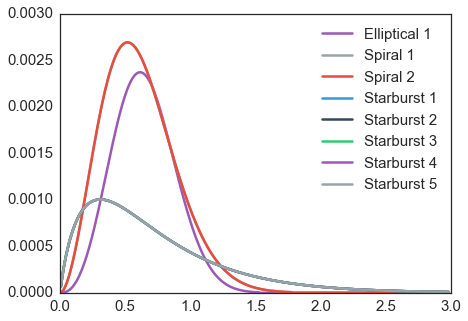

In [2]:
z_grid_binsize = 0.01
z_grid_edges = np.arange(0.0, 3.0, z_grid_binsize) # Some redshift grid
z_grid = (z_grid_edges[1:] + z_grid_edges[:-1])/2.

# Just some boolean indexing of templates used. Needed later for some BPZ fcts.
selectedtemplates = np.repeat(False, 8)

# Using all templates
templatetypesnb = (1, 2, 5) # nb of ellipticals, spirals, and starburst used in the 8-template library.
selectedtemplates[:] = True

# Uncomment that to use three templates using
#templatetypesnb = (1,1,1) #(1,2,8-3) 
#selectedtemplates[0:1] = True
nt = sum(templatetypesnb)

ellipticals = ['El_B2004a.sed'][0:templatetypesnb[0]]
spirals = ['Sbc_B2004a.sed','Scd_B2004a.sed'][0:templatetypesnb[1]]
irregulars = ['Im_B2004a.sed','SB3_B2004a.sed','SB2_B2004a.sed',
           'ssp_25Myr_z008.sed','ssp_5Myr_z008.sed'][0:templatetypesnb[2]]
template_names = [nm.replace('.sed','') for nm in ellipticals+spirals+irregulars]

# Import BPZ prior, i.e. p(z,t,m) distributions
m = 22.0 # some reference magnitude
p_z__t_m = bpz_prior(z_grid, m, templatetypesnb)

# Convenient function for template names
def mknames(nt):
    return ['Elliptical '+str(i+1) for i in range(nt[0])] \
    + ['Spiral '+str(i+1) for i in range(nt[1])]\
    + ['Starburst '+str(i+1) for i in range(nt[2])]

# Plot the priors for these templates
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
p = ax.plot(z_grid, p_z__t_m)
ax.legend(p, labels=mknames(templatetypesnb))

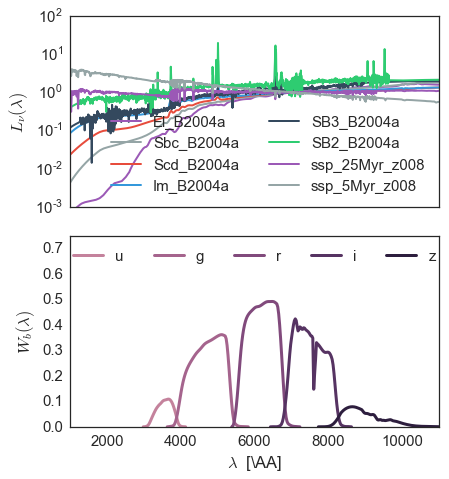

In [3]:
# Load and plot the templates and filters
palette = itertools.cycle(sns.color_palette())
fig, axs = plt.subplots(2, 1, figsize=(6.5, 7), sharex=True)
for i, template_name in enumerate(template_names):
    data = np.genfromtxt(bpzdir+'SED/'+template_name+'.sed')
    wavelength, template_sed = data[:,0], data[:,1] * data[:,0]**2
    fnorm = np.interp(7e3, wavelength, template_sed)
    axs[0].plot(wavelength, (template_sed / fnorm), label=template_names[i], 
                c=palette.next(), lw=2)
axs[0].legend(loc='lower right', ncol=2)
axs[0].set_ylabel(r'$L_\nu(\lambda)$')
axs[0].set_yscale('log')
axs[0].set_ylim([1e-3, 1e2])

ab_filters = ['u', 'g', 'r', 'i', 'z']
palette = itertools.cycle(sns.cubehelix_palette(5, light=0.6))
photometry_z = [np.genfromtxt(bpzdir+'AB/'+template_name+'.'+band+'.AB') for band in ab_filters]
filters = [np.genfromtxt(bpzdir+'FILTER/'+band+'.res') for band in ab_filters]
for f, data in zip(ab_filters, filters):
    axs[1].plot(data[:,0], data[:,1], label=f, c=palette.next(), lw=3)
axs[1].set_xlim([1e3, 1.1e4])
axs[1].set_ylim([0, 0.75])
axs[1].set_xlabel(r'$\lambda$  [\AA]')
axs[1].set_ylabel(r'$W_b(\lambda)$')
axs[1].legend(loc='upper center', ncol=5)
fig.tight_layout()

(0, 0.8)

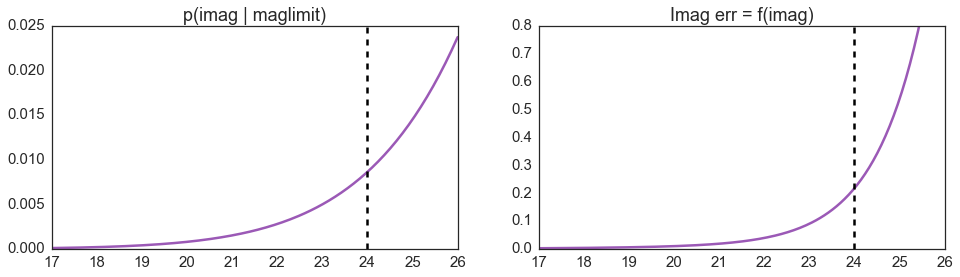

In [4]:
maglim = 24  # magnitude limit
off = 1.  # some offset
imag_grid = np.linspace(17, 26, num=200)  # grid for i magnitude
imagerr_grid = np.linspace(0, 0.4, num=200)  # grid for i magnitude error

# some parameters for prob(imagnitude)
alpha = 15.0 
beta = 2

# prob(imagnitude) distribution
p_imag = imag_grid**alpha*np.exp(-(imag_grid/(maglim-off))**beta)
p_imag /= p_imag.sum()

# imag errir distribution as function of mag limit, as in Rykoff et al
def imag_err(m, mlim):
    a, b = 4.56, 1
    k = 1
    sigmadet = 5
    teff = np.exp(a + b * (mlim - 21.))
    F = 10**(-0.4*(m-22.5))
    Flim = 10**(-0.4*(mlim-22.5))
    Fnoise = (Flim/sigmadet)**2 * k * teff - Flim
    return 2.5/np.log(10) * np.sqrt( (1 + Fnoise/F) / (F*k*teff))
    
fig, axs = plt.subplots(1, 2, figsize=(16,4))
axs[0].plot(imag_grid, p_imag)
axs[0].axvline(maglim, c='k', ls='dashed')
axs[0].set_title('p(imag | maglimit)')
axs[1].plot(imag_grid, imag_err(imag_grid, maglim))
axs[1].axvline(maglim, c='k', ls='dashed')
axs[1].set_title('Imag err = f(imag)')
axs[1].set_ylim([0, 0.8])

In [5]:
# Draw i magnitudes from a gridded prob(imag)
def draw_mag(nobj, imag_grid, p_imag):
    imag_grid_binsize = (imag_grid[1] - imag_grid[0])
    imag_grid_mid = (imag_grid[1:] + imag_grid[:-1])/2.0
    p_cumul = np.cumsum(p_imag) / np.sum(p_imag)
    pos = np.random.uniform(0.0, 1.0, size=nobj)
    res = np.zeros(nobj, dtype=int)
    for i in range(imag_grid.size-1):
        cond = np.logical_and(pos > p_cumul[i], pos <= p_cumul[i+1])
        res[cond] = i 
    return imag_grid_mid[res] + (np.random.rand(nobj) - 0.5)*imag_grid_binsize
    
# Draw types + redshifts for given z_grid, i magnitudes, and which types are used. 
def draw_types_and_redshifts(nobj, z_grid, imags, templatetypesnb):
    types = np.zeros(nobj, dtype=int)
    z_grid_binsize = (z_grid[1]-z_grid[0])
    z_grid_mid = (z_grid[1:]+z_grid[:-1])/2.0
    redshifts = np.zeros(nobj, dtype=float)
    redshiftlocs = np.zeros(nobj, dtype=int)
    nt = np.sum(templatetypesnb)    
    for ii in range(nobj):
        pos = np.random.uniform(0.0, 1.0, size=2)
        p_ztm = bpz_prior(z_grid, imags[ii], templatetypesnb)
        p_tm = p_ztm.sum(axis=0)
        p_tm_cumul = np.cumsum(p_tm) / np.sum(p_tm)
        for i in range(p_tm_cumul.size-1):
            if pos[0] > p_tm_cumul[i] and pos[0] <= p_tm_cumul[i+1]:
                types[ii] = i + 1
                break
        p_ztm_cumul = np.cumsum(p_ztm[:,types[ii]]) / np.sum(p_ztm[:,types[ii]])
        for i in range(p_ztm_cumul.size-1):
            if pos[1] > p_ztm_cumul[i] and pos[1] <= p_ztm_cumul[i+1]:
                redshiftlocs[ii] = i + 1
                redshifts[ii] = z_grid[i + 1] + (np.random.rand(1)-0.5)*z_grid_binsize
                break
    return redshifts, redshiftlocs, types

In [6]:
nobj = 100000
imags = draw_mag(nobj, imag_grid, p_imag)
imagerrs = imag_err(imags, maglim) 
imagswitherr_all = imags + imagerrs*np.random.randn(nobj)
ind = (1./imagerrs > 5.) # Doing SNR cut - keep galaxies detected at 5 sigma only
# Change the arrays to keep these objects only
nobj = ind.sum()
imags = imags[ind]
imagerrs = imagerrs[ind]
imagswitherr = imagswitherr_all[ind]
redshifts, redshiftlocs, types = draw_types_and_redshifts(nobj, z_grid, imags, templatetypesnb)

data = np.vstack((redshifts, types, imags)).T

# Define the edges of the redshift, type and imagnitude grid
z_grid_edges_coarse = np.arange(0.0, 3.0, 0.2)
types_edges = np.arange(nt+1)-0.5
imag_grid_edges = np.linspace(16, 26, num=10)
# Compute the histogram of true z-t-m values
truth_ztm_full, _ = np.histogramdd(data[:,:], 
                                   bins=[z_grid_edges_coarse,
                                         types_edges, 
                                         imag_grid_edges])

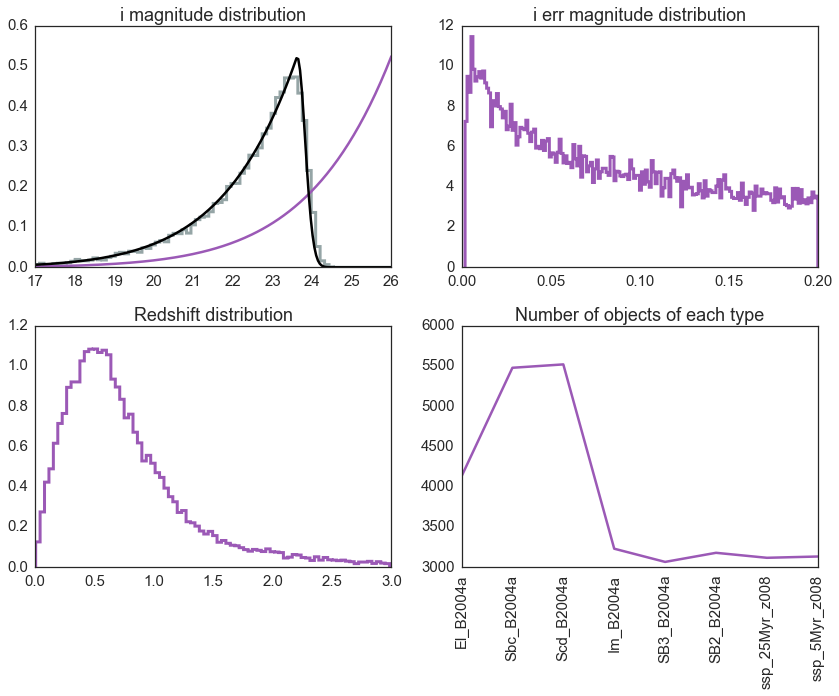

In [7]:
# We've kept objects detected at 5 sigma
# this should mimic a real survey selection.
# Let's verify this with some analytic prediction
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.ravel()
detprob = 1*p_imag 
ind = (imag_grid >= maglim - 0.4)
detprob[ind] *= np.exp( -0.5*((imag_grid[ind]-maglim+0.4)/0.2)**2)
#detprob[ind] *= ( 1 - scipy.special.erf((imag_grid[ind]-maglim+0.4)/0.4) )
detprob /= detprob.sum() * (imag_grid[1]-imag_grid[0])
#axs[0].hist(imags, normed=True, range=[imag_grid.min(), imag_grid.max()], bins=180, histtype='step', lw=3)
axs[0].plot(imag_grid, p_imag/np.sum(p_imag)/(imag_grid[1]-imag_grid[0]))
axs[0].plot(imag_grid, detprob, color='k')
axs[0].hist(imagswitherr, normed=True, range=[imag_grid.min(), imag_grid.max()], bins=80, histtype='step', lw=3)
axs[0].set_title('i magnitude distribution')
axs[1].hist(imagerrs, normed=True, range=[imagerrs.min(), imagerrs.max()], bins=180, histtype='step', lw=3)
axs[1].set_title('i err magnitude distribution')
axs[2].hist(redshifts, normed=True, range=[z_grid.min(), z_grid.max()], bins=80, histtype='step', lw=3)
axs[2].set_title('Redshift distribution')
counts = [np.sum(types==i) for i in range(nt)]
axs[3].plot(counts)
axs[3].set_title('Number of objects of each type')
axs[3].set_xticklabels(template_names, rotation=90)

fig.tight_layout()

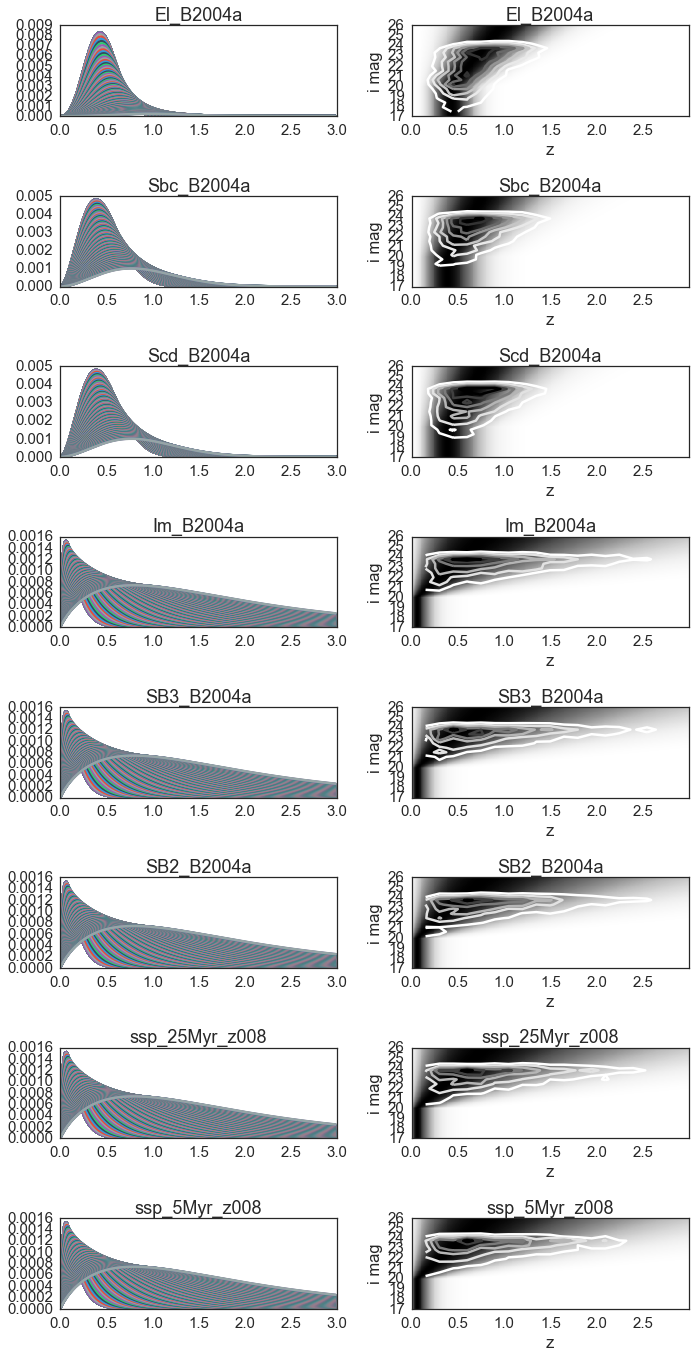

In [8]:
# Now plot the p(z,t,imag) priors and compare to what we've drawn
fig, axs = plt.subplots(nt, 2, figsize=(10, nt*2.4) )
templates = np.zeros((imag_grid.size, z_grid.size))
for i in range(nt):
    for j in range(imag_grid.size):
        templates[j,:] = bpz_prior(z_grid, imag_grid[j], templatetypesnb)[:,i]
    axs[i,0].plot(z_grid, templates[:,:].T)
    axs[i,0].set_title(template_names[i])

templates = np.zeros((imag_grid.size, z_grid.size))
for i in range(nt):
    ind = (types==i)
    for j in range(imag_grid.size):
        templates[j,:] = bpz_prior(z_grid, imag_grid[j], templatetypesnb)[:,i]
        templates[j,:] /= np.max(templates[j,:] )
    axs[i,1].pcolormesh(z_grid, imag_grid, templates)
    H, xedges, yedges = np.histogram2d(redshifts[ind], imags[ind], bins=20, range=[[z_grid.min(), z_grid.max()], [imag_grid.min(), imag_grid.max()]])
    axs[i,1].contour(xedges[1:],yedges[1:],H.T)
    axs[i,1].set_title(template_names[i])
    axs[i,1].set_xlabel('z')
    axs[i,1].set_ylabel('i mag')
plt.tight_layout()

In [9]:
# Let's truncate all these arrays and only keep a smaller number of objects
nobj = 10000
imags = imags[0:nobj]
imagerrs = imagerrs[0:nobj]
imagswitherr = imagswitherr[0:nobj]
redshifts = redshifts[0:nobj] 
redshiftlocs = redshiftlocs[0:nobj] 
types = types[0:nobj] 

filters = ['u', 'g', 'r', 'i', 'z'] # Which bands are used
reffilter = 2 # Which one is the reference? i band by default but could be anything.

# We will now use the BPZ routines to load the flux-redshift model for each template.
# We'll have interpolated and discretized versions
nf = len(filters)
nz = len(z_grid)
f_mod = zeros((nz,nt,nf))*0.
f_mod_interps = np.zeros((nt, nf), dtype=interp1d)
for it in range(nt):
    for jf in range(nf):
        if filters[jf][-4:]=='.res': filtro=filters[jf][:-4]
        else: filtro=filters[jf]
        model = join([template_names[it], filtro, 'AB'],'.')
        model_path = os.path.join(ab_dir, model)
        z_mod, f_mod_0 = get_data(model_path, (0, 1))
        f_mod_interps[it, jf] = InterpolatedUnivariateSpline(z_mod, f_mod_0)
        f_mod[:,it,jf] = match_resol(z_mod, f_mod_0, z_grid)

In [10]:
# f_mod denotes the (discretized or continuous) model flux-redshift curves
# Let's now get fluxes for all the objects we've drawn
f_obs_err = zeros((nobj,nf), dtype=float) # flux error
f_obs_noerr = zeros((nobj,nf), dtype=float) # noiseless flux
f_obs = zeros((nobj,nf), dtype=float)  # noisy flux
types = np.array(map(int, types))
for jf in range(nf):
    if jf == reffilter:
        f_obs_err[:,reffilter] = imagerrs * (1 + 0.1* np.random.randn(nobj))
        f_obs[:,reffilter] = imags + f_obs_err[:,reffilter] * np.random.randn(nobj)
        f_obs_noerr[:,reffilter] = imags
    else:
        cmod = np.array([-2.5*log10(clip(
                        f_mod_interps[types[i],jf](redshifts[i])/f_mod_interps[types[i],reffilter](redshifts[i])
                        ,1e-5,1e5)) for i in range(nobj)])
        f_obs_err[:,jf] = imagerrs * (1 + 0.1* np.random.randn(nobj))
        f_obs[:,jf] = imags + cmod + f_obs_err[:,jf] * np.random.randn(nobj)
        f_obs_noerr[:,jf] = imags + cmod 

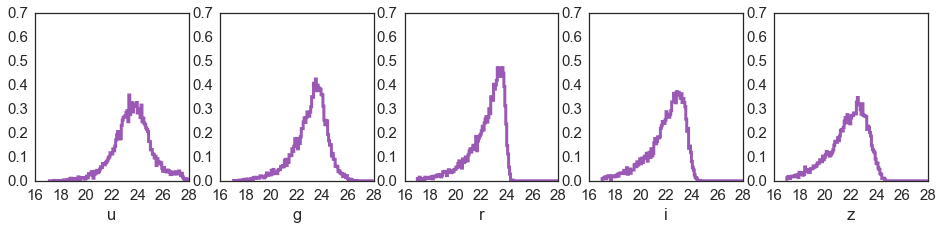

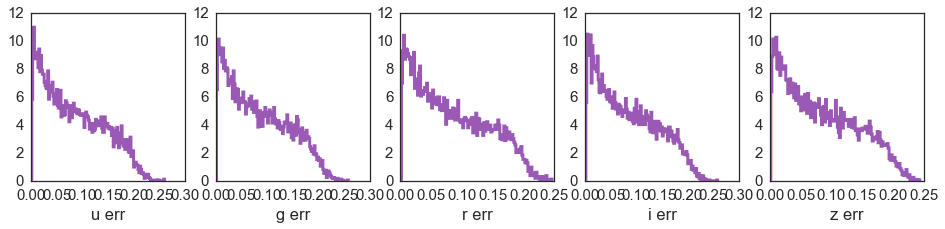

In [11]:
# Let's visualize the fluxes
fig, axs = plt.subplots(1, nf, figsize=(16,3))
for jf in range(nf):
    axs[jf].hist(f_obs[:,jf], normed=True, 
                 range=[imag_grid.min(), imag_grid.max()+2], 
                 bins=150, histtype='step', lw=3)
    axs[jf].set_ylim([0,0.7])
    axs[jf].set_xlabel(filters[jf])
fig, axs = plt.subplots(1, nf, figsize=(16,3))
for jf in range(nf):
    axs[jf].hist(f_obs_err[:,jf], normed=True, bins=150, histtype='step', lw=3)
    axs[jf].set_xlabel(filters[jf]+' err')

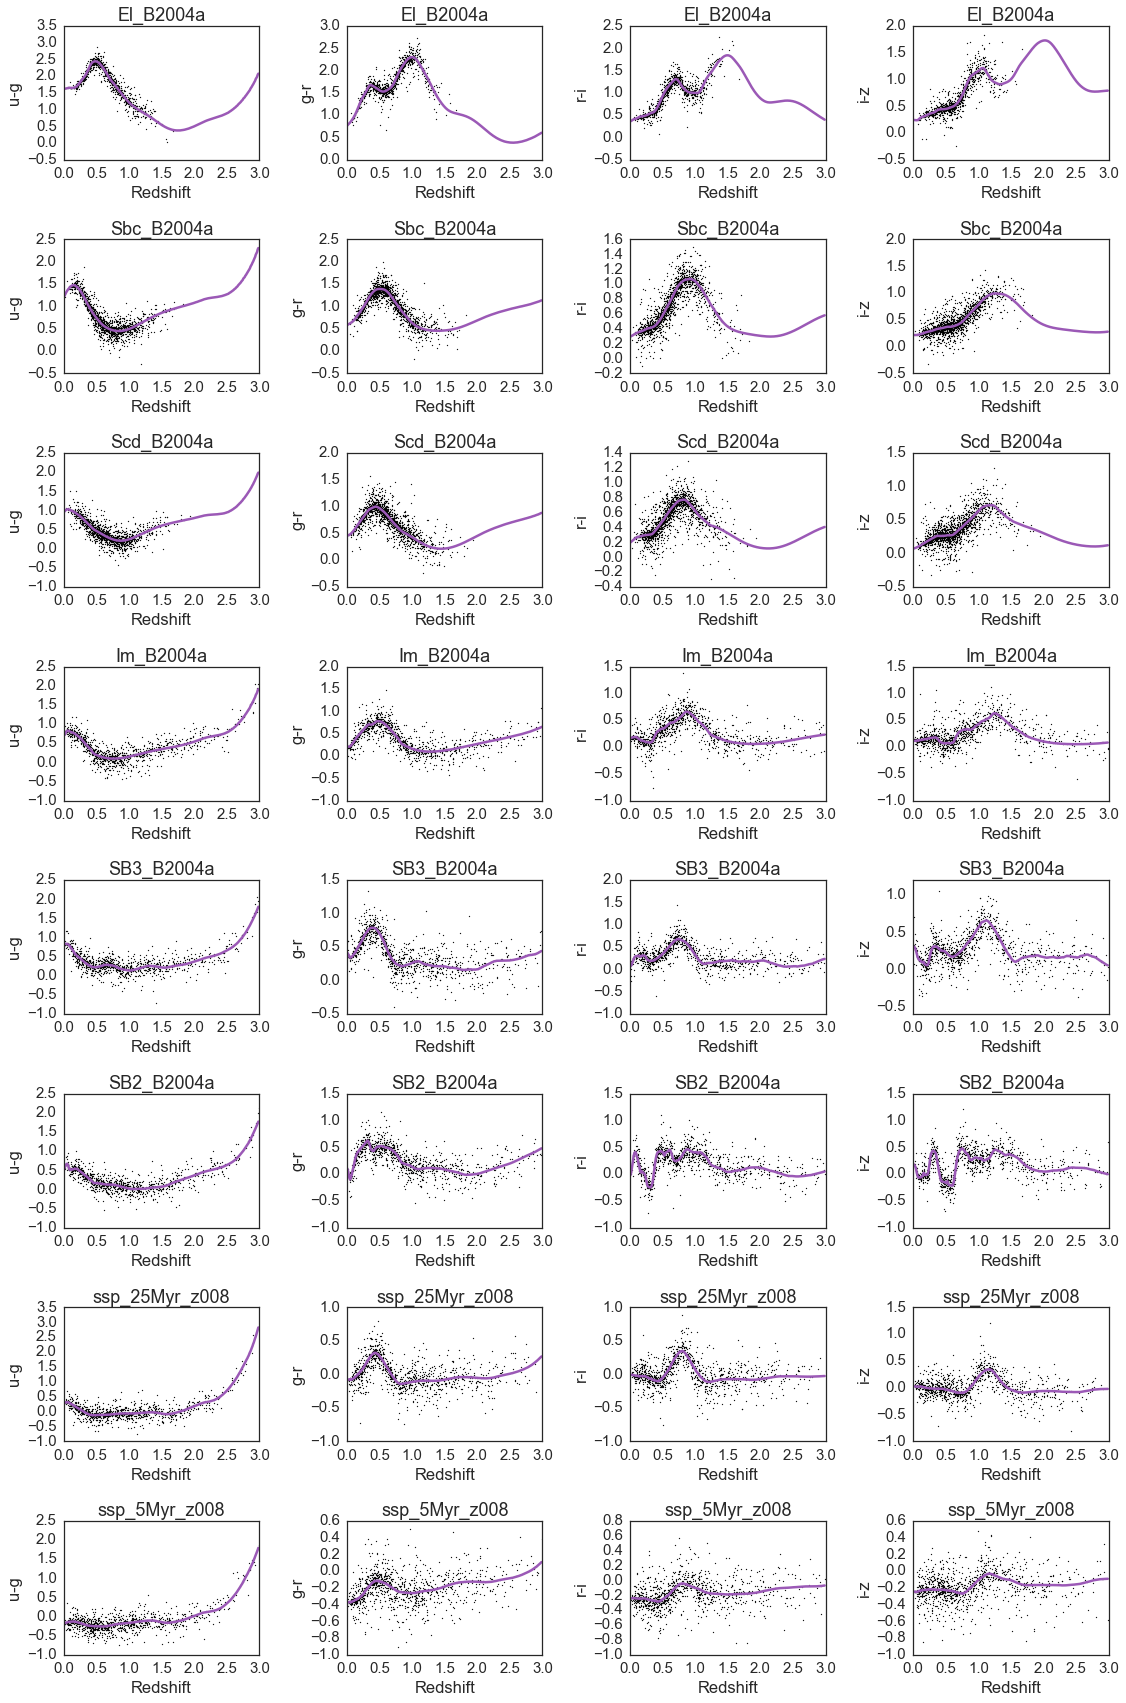

In [12]:
# Let's plot the model and the noisy fluxes for our mock catalogue
fig, axs = plt.subplots(nt, nf-1, figsize=(16,nt*3))
for it in range(nt):
    ind = (types == it)
    for jf in range(nf-1):
        theax = axs[it,jf]
        colour = -2.5*log10(clip(f_mod[:,it,jf] / f_mod[:,it,jf+1], 1e-5, 1e5))
        colourobj = f_obs[:,jf] - f_obs[:,jf+1]
        p = theax.scatter(redshifts[ind], colourobj[ind], c='k', s=1)
        p = theax.plot(z_grid, colour)
        theax.set_title(template_names[it])
        theax.set_xlabel('Redshift')
        theax.set_ylabel(filters[jf]+'-'+filters[jf+1])
        theax.set_xlim([0,3])
fig.tight_layout()

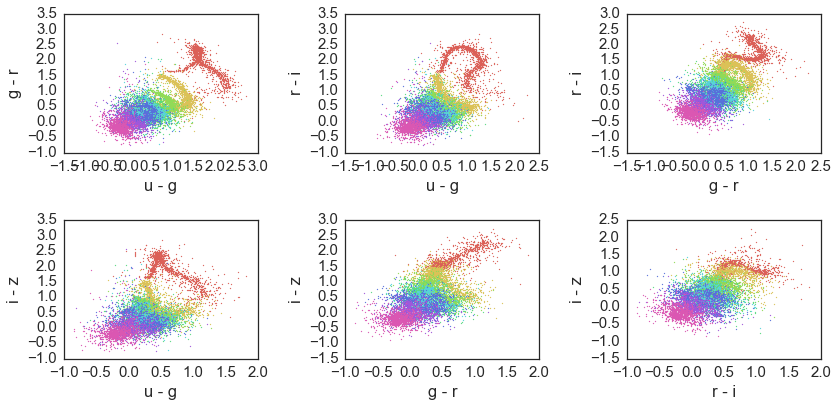

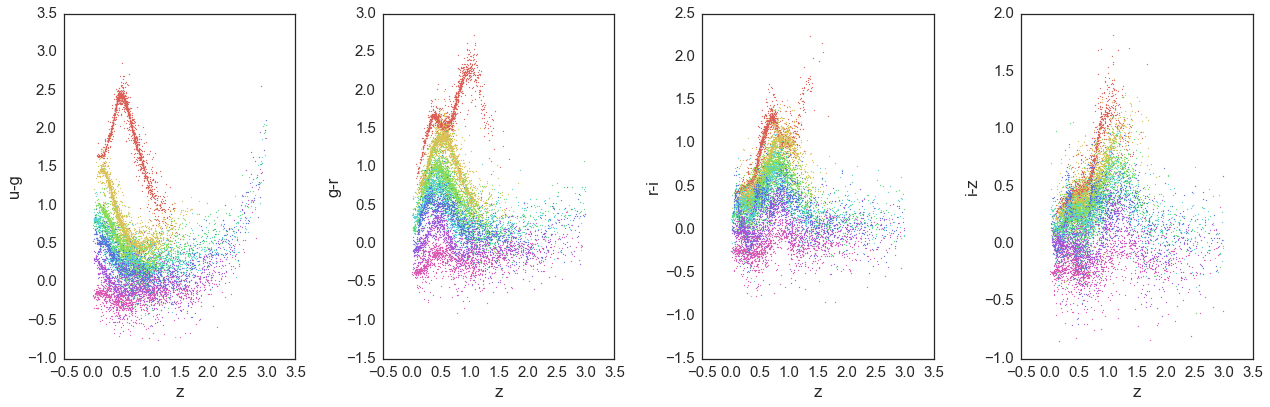

In [13]:
# Another way to visualize it: colours vs colours
cols = sns.color_palette("hls", nt)
fig, axs = plt.subplots(2, (nf-1)*(nf-2)/4, figsize=(12, 6))
axs = axs.ravel()
off = - 1
for jf in range(nf-1):
    for jf2 in range(jf):
        off += 1
        for it in range(nt):
            ind = (types == it)
            colourobj1 = f_obs[ind,jf] - f_obs[ind,jf+1]
            colourobj2 = f_obs[ind,jf2] - f_obs[ind,jf2+1]
            p = axs[off].scatter(colourobj1, colourobj2, color=cols[it], s=1)
            axs[off].set_ylabel(filters[jf]+' - '+filters[jf+1])
            axs[off].set_xlabel(filters[jf2]+' - '+filters[jf2+1])
fig.tight_layout()

fig, axs = plt.subplots(1, nf-1, figsize=(18,6))
for it in range(nt):
    ind = (types == it)
    for jf in range(nf-1):
        colourobj = f_obs[:,jf] - f_obs[:,jf+1]
        p = axs[jf].scatter(redshifts[ind], colourobj[ind], color=cols[it], s=1)
        axs[jf].set_xlabel('z')
        axs[jf].set_ylabel(filters[jf]+'-'+filters[jf+1])
fig.tight_layout()

In [14]:
# Let's use the same templats to compute the likelihood functions of all these objects
# In flux space
fac = 20 # This is a resolution factor
# We need to compute the likelihood at high resolution and then bin it.
bpz_z_binsize = 0.01 # This is the high resolution bin size
# the low resolution binsize is fac * bpz_z_binsize
bpz_z_edges = 1*z_grid_edges
bpz_z = 1*z_grid
types_edges = np.arange(nt+1)-0.5

# Re-build model using BPZ, at high resolution this time.
nz = len(bpz_z)
f_mod = zeros((nz,nt,nf))*0.
for it in range(nt):
    for jf in range(nf):
        if filters[jf][-4:]=='.res': filtro = filters[jf][:-4]
        else: filtro = filters[jf]
        model = join([template_names[it], filtro, 'AB'],'.')
        model_path = os.path.join(ab_dir, model)
        zo, f_mod_0 = get_data(model_path, (0,1))
        f_mod[:,it,jf] = match_resol(zo, f_mod_0, bpz_z)
# Run BPZ likelihood
# F_obs is for fluxes, ff_obs is for colors
ff_obs = (10.**(-.4*f_obs))
ff_obs_err = (10.**(.4*np.abs(f_obs_err))-1.)*ff_obs
f_mod_log = -2.5*log10(f_mod)

# This is just a bunch of redefinitions to re-bin all useful quantities
z_grid_binsize = fac * bpz_z_binsize
if fac == 1:
    z_grid_edges = bpz_z_edges
else:
    z_grid_edges = np.array([bpz_z_edges[i] for i in np.arange(0, bpz_z_edges.size, fac)])
z_grid = (z_grid_edges[1:]+z_grid_edges[:-1])/2.0
bpz_z_ini = 1*bpz_z
bpz_z_edges_ini = 1*bpz_z_edges
bpz_z = z_grid
bpz_z_edges = z_grid_edges
len_new = bpz_z_ini.size / fac

# Compute likelihood for each object using BPZ function, then multiply with prior.
bpz_like_fine_multitypes = zeros((nobj, bpz_z_ini.size, nt), dtype=float) # Binned liklihood at full resolution
bpz_like_multitypes = zeros((nobj, bpz_z.size, nt), dtype=float) # Coarce binned likelihood 
bpz_posterior_multitypes = zeros((nobj, bpz_z.size, nt), dtype=float) # Coarce posterior 
bpz_like_truetype = zeros((nobj, bpz_z.size), dtype=float)
for i in range(nobj):
    if i % 1000 == 0: 
        print i, # Print number every 1000 objects.
    ff = p_c_z_t(ff_obs[i,:], ff_obs_err[i,:], f_mod[:,:,:]).likelihood
    p_i = prior(z_grid, ff_obs[i,reffilter], 'hdfn_gen', len(selectedtemplates), 0)[:,selectedtemplates]
    bpz_like_fine_multitypes[i,:,:] = ff # Fine resolution
    for kk in range(len_new):
        bpz_like_multitypes[i,kk,:] = np.mean(ff[kk*fac:(kk+1)*fac,:], axis=0) # Re-bin
        bpz_like_truetype[i,:] = bpz_like_multitypes[i,kk,types[i]] # true type
    bpz_posterior_multitypes[i,:,:] = bpz_like_multitypes[i,:,:] * p_i

0 1000 2000 3000 4000 5000 6000 7000 8000 9000


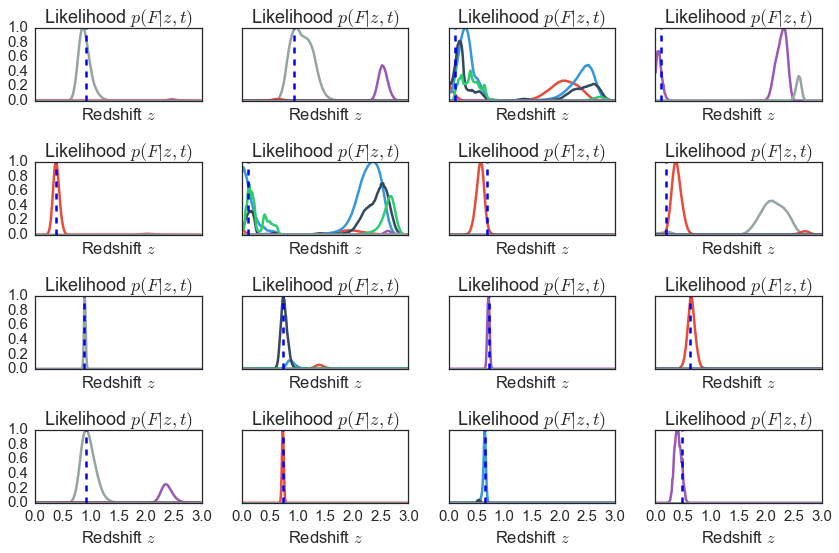

In [15]:
# plot likelihood function for a few objects
# color coded by type.
fig2, axs = plt.subplots(4, 4, figsize=(12, 8), sharex=True, sharey=True)
axs = axs.ravel()
ri = np.random.choice(np.arange(nobj), axs.size, replace=False)
for i in range(len(ri)):
    theax = axs[i]
    theax.plot(bpz_z_ini, bpz_like_fine_multitypes[ri[i],:,:], alpha=1)
    theax.axvline(redshifts[ri[i]], ls='dashed')
    theax.set_title(r'Likelihood $p(F|z,t)$')
    theax.set_xlabel(r'Redshift $z$')
fig2.tight_layout()